Weak perturbation
=================

In this first numerical experiment we consider the propagation of a small perturbation in a collisionless plasma model. The perturbation is initiated by a thin slab of fluid slowly moving with respect to the surrounding resting fluid. The slab is translationally invariant in the y direction and moving in the x direction.
We qualify the perturbation as "small" if the initial speed of the slab is small with respect to the sound speed $c=\sqrt{\gamma T}$, where is the adiabatic index and $T$ the fluid temperature.

In [4]:
root_path  = "/home/user/PHARE/fluid_kinetic_class/2024/run/weak"
phare_path = "/home/user/PHARE/"

In [1]:
import os
import sys
phare_root = os.path.expanduser(phare_path)
sys.path.append(os.path.join(phare_root, "pyphare"))

from pyphare.pharesee.run import Run
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as gf
from numpy import polyfit
from scipy.signal import find_peaks
%matplotlib widget

# Misc functions to get data

In [3]:
def get_velocities(r,times, sigma=6):
    for it,t in enumerate(times):
        Vi = r.GetVi(t, merged=True)
        Vix = Vi["Vx"][0]
        xV = Vi["Vx"][1][0]
        if sigma >0:
            v = gf(Vix(xV),sigma)
        else:
            v = Vix(xV)
        if it==0 :
            vt = np.zeros((len(v),len(times)))
        vt[:,it] = v
    return xV, vt

def get_densities(r,times, sigma=6):
    for it,t in enumerate(times):
        N = r.GetNi(t, merged=True)
        Ni = N["rho"][0]
        x = N["rho"][1][0]
        if sigma >0:
            n = gf(Ni(x),sigma)
        else:
            n = Ni(x)
        if it==0 :
            nt = np.zeros((len(n),len(times)))
        nt[:,it] = n
    return x, nt

def get_electric(r,times, sigma=6):
    for it,t in enumerate(times):
        E = r.GetE(t, merged=True)
        Ex = E["Ex"][0]
        x = E["Ex"][1][0]
        if sigma >0:
            e = gf(Ex(x),sigma)
        else:
            e = Ex(x)
        if it==0 :
            et = np.zeros((len(e),len(times)))
        et[:,it] = e
    return x, et

def get_peaks(x,Vs):
    nt = Vs.shape[1]
    positions  = np.zeros((nt,2))
    amplitudes = np.zeros((nt,2))
    for it in range(nt):
        ps = find_peaks(Vs[:,it], height=0.010)
        if (len(ps[0])==1):
            positions[it,0] = x[ps[0]]
            positions[it,1] = x[ps[0]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][0],it]
        else:
            positions[it,0]  = x[ps[0][0]]
            positions[it,1]  = x[ps[0][1]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][1],it]
    return positions, amplitudes

def profiles(times, x, Vs, positions, temperature):
    fig, ax = plt.subplots()
    for it,t in enumerate(times):
        ax.plot(x, Vs[:,it], label=r"t={:6.4f}".format(t))
        ax.set_ylim((-0.03, 0.1))
        ax.axhline(0, ls='--', color='k')
        for p in positions[it,:]:
            ax.axvline(p, color="gray", ls="-.")
    ax.set_title("$T_e$ = {:6.4f}".format(temperature))
    ax.legend()

def propagation(times, positions, temperature):
    fig,ax = plt.subplots()
    ax.plot(times,positions[:,0], marker="o", color="r", ls="None")
    vl,originl = polyfit(times, positions[:,0], 1)
    ax.plot(times, times*vl+originl, color="r")

    ax.plot(times,positions[:,1], marker="o", color="b", ls="None")
    vr,originr = polyfit(times, positions[:,1], 1)
    ax.plot(times, times*vr+originr, color="b")
    ax.set_title("T = {:6.4f}, Vl = {:6.4f}, Vr = {:6.4f}".format(temperature, vl, vr))

def damping(times, amplitudes, **kw):
    fig,ax = plt.subplots()
    ax.plot(times,amplitudes[:,0], marker="o", color="r", ls="None")
    ax.plot(times,amplitudes[:,1], marker="o", color="b", ls="None")
    ax.set_ylim((0,0.1))

# WP1

## Goal

You will execute 4 runs. The runs only differ by the electron temperature. 

- $T_e = 0.0$
- $T_e = 0.05$
- $T_e = 0.25$
- $T_e = 0.5$
- $T_e = 2.5$

## Run PHARE

- Open a terminal (File>New>Terminal)
- execute `pwd`, you should see `/home/user/PHARE` indicating you're in the PHARE directory
- execute `git clone https://github.com/PHAREHUB/fluid_kinetic_class`
- execute `cd fluid_kinetic_class/2024/run/weak/`


In there you will see a script called `wp1.py` that will configure a PHARE simulation for you.\
To run it for a temperature $Te= 0.1$ do:

```bash
python3 wp1.py 0.1
```

This should run and produce outputs in the directory:

- `wp_0.1/`


To run the analysis for a specific run you did, execute cells below after changing the value of the variable  `Te` to the one associated with the run you want to see.



In [12]:
Te=0.2


In [13]:
path = root_path+"/"+f"wp_{Te}"
times = np.asarray((0, 20, 40, 60, 80, 100))
r = Run(path)
x, Vs = get_velocities(r,times, sigma=6)

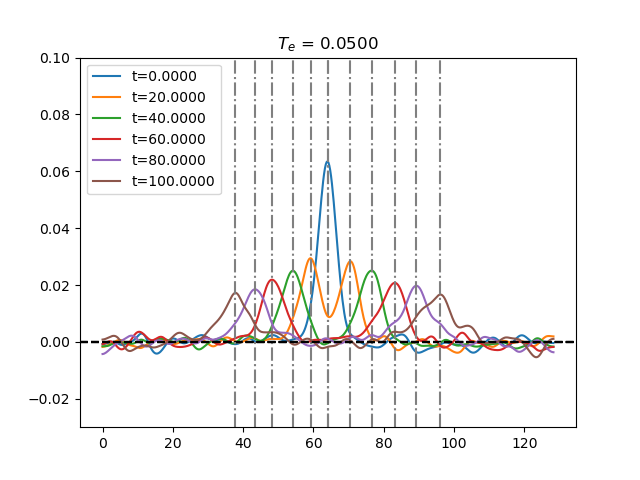

In [14]:
positions, amplitudes = get_peaks(x,Vs)
profiles(times, x, Vs, positions, Te)

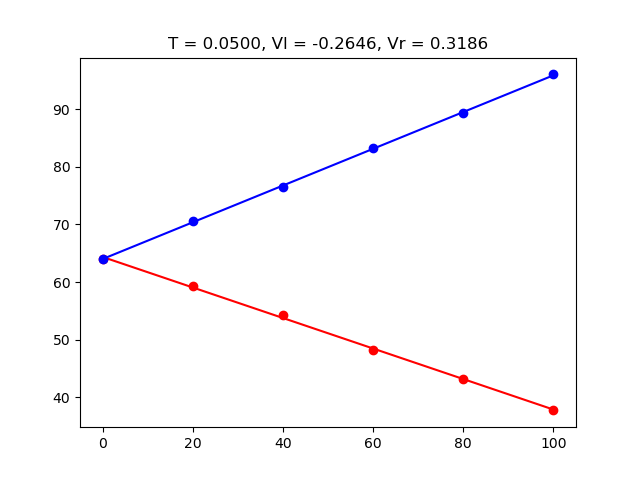

In [15]:
propagation(times, positions, Te)

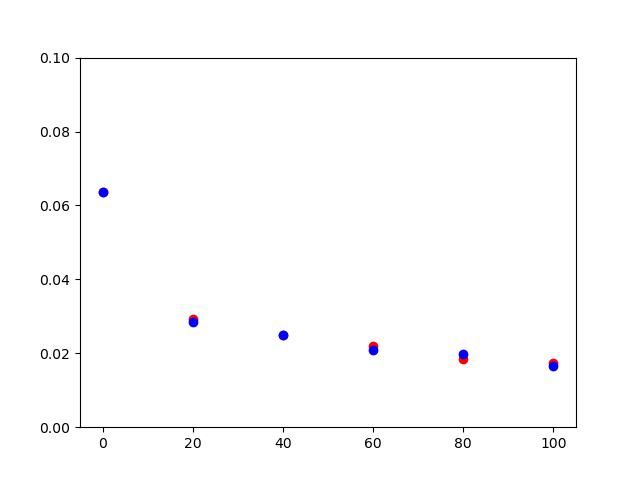

In [16]:
damping(times, amplitudes)

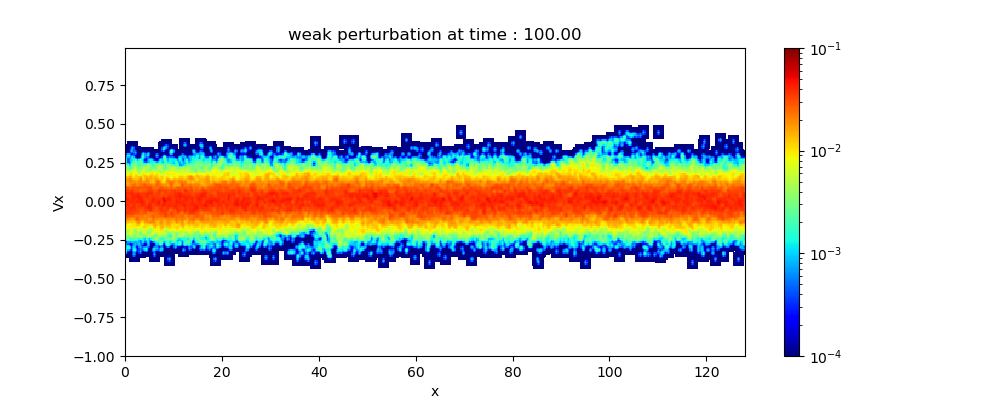

In [17]:
time=100
r = Run(root_path+"/"+"wp1")
ions = r.GetParticles(time, ["protons",])
fig, ax1 = plt.subplots(figsize=(10,4))
p,f = ions.dist_plot(axis=("x", "Vx"),
                     ax=ax1,            # default creates the figure
                     norm = 0.4,     # max value, min is 0
                     finest=True,  # only consider finest particles possible
                     gaussian_filter_sigma=1,
                     vmin=-1,vmax=1,
                     dv=0.01,
                     title="weak perturbation at time : {:.2f}".format(time), # figure title
                    )

In [18]:
Te = 0.05
Ti = 0.01
Gamma_e = 1
Gamma_i = 3
print("ion acoustic speed : ", np.sqrt(Gamma_e*Te+Gamma_i*Ti))

ion acoustic speed :  0.282842712474619
